In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv('data/red_normal.csv')
#data = pd.read_csv('data/white_normal.csv')
#data = pd.read_csv('data/wine_normal.csv')
#data = pd.read_csv('train/wine_data.csv', usecols=range(14)[1:])

In [3]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
0,-0.528194,0.981974,-1.391037,-0.590653,-0.231744,-0.247049,-0.159545,0.558100,1.288240,-0.579025,-0.959946,5
1,-0.298454,1.693658,-1.391037,0.296646,0.535000,0.992454,0.854271,0.028252,-0.719708,0.128910,-0.584594,5
2,-0.298454,1.235222,-1.185699,-0.052744,0.342271,0.214135,0.523767,0.134222,-0.331073,-0.048074,-0.584594,5
3,1.654339,-1.592344,1.483689,-0.590653,-0.271015,0.402953,0.684389,0.664069,-0.978798,-0.461036,-0.584594,6
4,-0.528194,0.981974,-1.391037,-0.590653,-0.231744,-0.247049,-0.159545,0.558100,1.288240,-0.579025,-0.959946,5


In [4]:
data.shape

(1599, 12)

In [5]:
if 'type' in data.columns:
    data = pd.get_dummies(data, columns = ['type'])
    data.drop('type_white', axis=1, inplace=True)
temp = data['quality']
data.drop('quality', axis=1, inplace=True)
data['quality'] = temp

In [6]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
0,-0.528194,0.981974,-1.391037,-0.590653,-0.231744,-0.247049,-0.159545,0.558100,1.288240,-0.579025,-0.959946,5
1,-0.298454,1.693658,-1.391037,0.296646,0.535000,0.992454,0.854271,0.028252,-0.719708,0.128910,-0.584594,5
2,-0.298454,1.235222,-1.185699,-0.052744,0.342271,0.214135,0.523767,0.134222,-0.331073,-0.048074,-0.584594,5
3,1.654339,-1.592344,1.483689,-0.590653,-0.271015,0.402953,0.684389,0.664069,-0.978798,-0.461036,-0.584594,6
4,-0.528194,0.981974,-1.391037,-0.590653,-0.231744,-0.247049,-0.159545,0.558100,1.288240,-0.579025,-0.959946,5


Our approach is to think about the train as points sitting in $\mathbb R^{12}$ and we conjecture that they have some structure in the form of lower dimensional shape. To have a more concrete visualization, think about $\mathbb R^3$ an our train might have the shape of a sphere, a torus, a bent sheet of paper etc.

Obviously, the train is going to be pretty irregular and we don't expect it to form a really nice submanifold. Nonetheless, we draw from the notion of a triangulization from geometry. Roughly, it says that we can approximate any shape by only using linear pieces without changing the geometric properties too much.

To translate this into our setting, we are going to divide the ranges of the features into a grid and for each small piece we are going to find a linear model to predict the quality. Given a new example, we only need to find where it lies on the grid and make a prediction using the closest model.

In [7]:
from sklearn.decomposition import PCA

In [8]:
data, temp = data.iloc[:,:-1], data.ix[:,'quality']

In [9]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol
0,-0.528194,0.981974,-1.391037,-0.590653,-0.231744,-0.247049,-0.159545,0.558100,1.288240,-0.579025,-0.959946
1,-0.298454,1.693658,-1.391037,0.296646,0.535000,0.992454,0.854271,0.028252,-0.719708,0.128910,-0.584594
2,-0.298454,1.235222,-1.185699,-0.052744,0.342271,0.214135,0.523767,0.134222,-0.331073,-0.048074,-0.584594
3,1.654339,-1.592344,1.483689,-0.590653,-0.271015,0.402953,0.684389,0.664069,-0.978798,-0.461036,-0.584594
4,-0.528194,0.981974,-1.391037,-0.590653,-0.231744,-0.247049,-0.159545,0.558100,1.288240,-0.579025,-0.959946


In [10]:
pca = PCA(svd_solver='full')

In [11]:
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [12]:
pca.explained_variance_ratio_

array([ 0.28719393,  0.18670226,  0.14506158,  0.10240888,  0.09009915,
        0.0573764 ,  0.05027254,  0.03728912,  0.02383258,  0.01495578,
        0.00480778])

In [13]:
data = pd.DataFrame(pca.transform(data))

In [14]:
data

,0,1,2,3,4,5,6,7,8,9,10
0,-1.586088,0.804247,-1.564590,0.085049,-0.204236,-0.972646,0.240991,-0.404762,-0.156102,0.207574,-0.018279
1,-0.610215,2.169355,-0.579698,0.282568,0.294268,0.974693,0.861676,0.641237,-0.414439,0.005392,-0.047086
2,-0.635191,1.357627,-0.874340,0.319933,0.101116,0.465593,0.566424,0.411028,-0.157507,0.267932,-0.075574
3,2.283587,-0.117872,0.905420,0.003608,-1.971278,-0.215776,-0.378722,-0.485402,-0.064289,0.237299,0.244336
4,-1.586088,0.804247,-1.564590,0.085049,-0.204236,-0.972646,0.240991,-0.404762,-0.156102,0.207574,-0.018279
5,-1.600247,0.959499,-1.270986,0.181695,-0.390301,-1.014441,0.218131,-0.470594,-0.228568,0.280569,-0.052105
6,-1.239662,0.898098,-0.717226,0.316498,-1.582987,0.140053,0.141596,0.072979,-0.098744,0.427969,0.013162
7,-2.468405,-0.403463,-0.952373,0.831540,-1.307587,0.271058,0.347188,-0.237573,-0.589255,-0.364281,0.132832
8,-1.084221,-0.225895,-1.583744,0.175093,-0.404933,-0.527665,0.091386,0.400845,-0.555953,-0.083697,0.069259
9,0.624119,1.491500,1.267574,-1.765650,1.380069,-0.600414,-0.093186,1.013550,0.899516,0.151979,0.098495


In [15]:
#data[['type_red', 'quality']] = temp
data['quality'] = temp

In [16]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,quality
0,-1.586088,0.804247,-1.564590,0.085049,-0.204236,-0.972646,0.240991,-0.404762,-0.156102,0.207574,-0.018279,5
1,-0.610215,2.169355,-0.579698,0.282568,0.294268,0.974693,0.861676,0.641237,-0.414439,0.005392,-0.047086,5
2,-0.635191,1.357627,-0.874340,0.319933,0.101116,0.465593,0.566424,0.411028,-0.157507,0.267932,-0.075574,5
3,2.283587,-0.117872,0.905420,0.003608,-1.971278,-0.215776,-0.378722,-0.485402,-0.064289,0.237299,0.244336,6
4,-1.586088,0.804247,-1.564590,0.085049,-0.204236,-0.972646,0.240991,-0.404762,-0.156102,0.207574,-0.018279,5


In [17]:
data.rename(columns={0:'alcohol', 1:'density', 2:'volatile_acidity'}, inplace=True)

In [18]:
data.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,10,quality
0,-1.586088,0.804247,-1.564590,0.085049,-0.204236,-0.972646,0.240991,-0.404762,-0.156102,0.207574,-0.018279,5
1,-0.610215,2.169355,-0.579698,0.282568,0.294268,0.974693,0.861676,0.641237,-0.414439,0.005392,-0.047086,5
2,-0.635191,1.357627,-0.874340,0.319933,0.101116,0.465593,0.566424,0.411028,-0.157507,0.267932,-0.075574,5
3,2.283587,-0.117872,0.905420,0.003608,-1.971278,-0.215776,-0.378722,-0.485402,-0.064289,0.237299,0.244336,6
4,-1.586088,0.804247,-1.564590,0.085049,-0.204236,-0.972646,0.240991,-0.404762,-0.156102,0.207574,-0.018279,5


In [19]:
train = data.sample(frac=0.8).sort_index()

In [20]:
train_index = train.index

In [21]:
train_index.shape

(1279,)

In [22]:
test = data.iloc[~data.index.isin(train_index)]

In [23]:
test.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,10,quality
2,-0.635191,1.357627,-0.874340,0.319933,0.101116,0.465593,0.566424,0.411028,-0.157507,0.267932,-0.075574,5
3,2.283587,-0.117872,0.905420,0.003608,-1.971278,-0.215776,-0.378722,-0.485402,-0.064289,0.237299,0.244336,6
7,-2.468405,-0.403463,-0.952373,0.831540,-1.307587,0.271058,0.347188,-0.237573,-0.589255,-0.364281,0.132832,7
11,0.624119,1.491500,1.267574,-1.765650,1.380069,-0.600414,-0.093186,1.013550,0.899516,0.151979,0.098495,5
13,1.500474,0.207745,0.060234,3.849188,2.474407,-1.768374,2.127712,1.207379,0.634067,-0.538641,0.166687,5


In [24]:
train.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,10,quality
0,-1.586088,0.804247,-1.564590,0.085049,-0.204236,-0.972646,0.240991,-0.404762,-0.156102,0.207574,-0.018279,5
1,-0.610215,2.169355,-0.579698,0.282568,0.294268,0.974693,0.861676,0.641237,-0.414439,0.005392,-0.047086,5
4,-1.586088,0.804247,-1.564590,0.085049,-0.204236,-0.972646,0.240991,-0.404762,-0.156102,0.207574,-0.018279,5
5,-1.600247,0.959499,-1.270986,0.181695,-0.390301,-1.014441,0.218131,-0.470594,-0.228568,0.280569,-0.052105,5
6,-1.239662,0.898098,-0.717226,0.316498,-1.582987,0.140053,0.141596,0.072979,-0.098744,0.427969,0.013162,5


In [25]:
train.describe()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,10,quality
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,0.017316,-0.027685,-0.019228,0.001628,0.006968,0.006394,0.014998,-0.000311,-0.006413,0.009505,0.005211,5.640344
std,1.789998,1.427820,1.265010,1.068085,0.990669,0.805829,0.733811,0.638095,0.508485,0.412328,0.231947,0.812923
min,-5.679774,-4.399326,-3.563980,-3.997326,-3.515314,-2.832578,-2.903157,-2.197407,-1.446703,-1.636011,-0.990522,3.000000
25%,-1.281590,-1.032726,-0.877729,-0.503242,-0.678032,-0.528226,-0.424207,-0.403413,-0.356211,-0.259661,-0.125488,5.000000
50%,-0.180350,0.093048,-0.053727,0.008401,-0.080754,0.027616,-0.011349,-0.024674,-0.041387,-0.022894,0.003043,6.000000
75%,1.131305,0.931873,0.764713,0.491197,0.569133,0.536384,0.467805,0.403071,0.299714,0.252771,0.140594,6.000000
max,7.678631,4.809924,4.556445,5.683832,5.585587,2.982578,3.561323,3.438804,3.301722,2.126181,1.087956,8.000000


In [26]:
# Dictionary representing the gird. Each row represents a feature and the columns the partitions.
# The shape of this matrix is a hyperparameter of our model.
# The distance notion that we use is also a hyperparameter.
grid = {}
for name in ['alcohol', 'density', 'volatile_acidity']: #train.columns:
    if not "type" in name:
        grid[name] = []

In [27]:
grid

{'alcohol': [], 'density': [], 'volatile_acidity': []}

In [28]:
# We start small, for each feature we just give one separation point.
for element in grid:
    grid[element] = np.median(train[element])

In [29]:
grid

{'alcohol': -0.18035018008515172,
 'density': 0.093047996921220372,
 'volatile_acidity': -0.053726831517264671}

This generates a split of the train into $2^{12}$ pieces. That is 4096 different pieces so we don't have enough train to support this partition. We need to select a subset of the feautes.

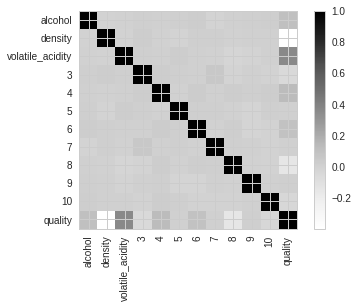

In [30]:
tick_marks = [i for i in range(len(train.columns))]
plt.imshow(train.corr(), interpolation='nearest')
plt.colorbar()
plt.xticks(tick_marks, train.columns, rotation='vertical')
plt.yticks(tick_marks, train.columns)
plt.show()

In [31]:
correlations = pd.DataFrame(train.corr()['quality']).apply(np.abs)
correlations.sort_values(by='quality', ascending=False)

,quality
quality,1.000000
density,0.397427
volatile_acidity,0.362889
8,0.147957
4,0.130672
alcohol,0.105748
6,0.091018
3,0.053101
10,0.036393
9,0.013332


It seems reasonable to split along alcohol, density and volatile_acidity. This way we will have 8 different partitions

In [32]:
dfs = []

In [33]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density > grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [34]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density > grid["density"] ) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [35]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [36]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [37]:
dfs.append(train[(train.alcohol < grid["alcohol"])
                 & (train.density > grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [38]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density > grid["density"])
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [39]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [40]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [41]:
for df in dfs:
    print(df.shape)

(182, 12)
(122, 12)
(169, 12)
(166, 12)
(154, 12)
(179, 12)
(134, 12)
(168, 12)


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score

In [43]:
def trainLG(df):
    X, y = df.ix[:,:-1], df['quality']
    clf = LogisticRegression(penalty='l2', 
                             C=10,
                             n_jobs=-1)
    clf.fit(X, y)
    return clf

In [44]:
clfs = []
for df in dfs:
    clfs.append(trainLG(df))

In [45]:
X_test, y_test = test.ix[:,:-1], test['quality']

In [46]:
X_test.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,10
2,-0.635191,1.357627,-0.874340,0.319933,0.101116,0.465593,0.566424,0.411028,-0.157507,0.267932,-0.075574
3,2.283587,-0.117872,0.905420,0.003608,-1.971278,-0.215776,-0.378722,-0.485402,-0.064289,0.237299,0.244336
7,-2.468405,-0.403463,-0.952373,0.831540,-1.307587,0.271058,0.347188,-0.237573,-0.589255,-0.364281,0.132832
11,0.624119,1.491500,1.267574,-1.765650,1.380069,-0.600414,-0.093186,1.013550,0.899516,0.151979,0.098495
13,1.500474,0.207745,0.060234,3.849188,2.474407,-1.768374,2.127712,1.207379,0.634067,-0.538641,0.166687


In [47]:
def getPiece(row): 
    if row.alcohol > grid["alcohol"]:
        if row.density > grid["density"]:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 0
            else:
                return 1
        else:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 2
            else:
                return 3
    else:
        if row.density > grid["density"]:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 4
            else:
                return 5
        else:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 6
            else:
                return 7
        

def generatePrediction(df):
    y_pred = []
    for idx in df.index:
        temp = getPiece(df.loc[idx])
        jdx = clfs[temp].predict(df.loc[idx].reshape(1,-1))
        y_pred.append(jdx)
    return pd.DataFrame(y_pred)

In [48]:
y_pred = generatePrediction(X_test)

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


# MAE

In [49]:
mean_absolute_error(y_test, y_pred)

0.42499999999999999

# ACCURACY

In [50]:
accuracy_score(y_test, y_pred)

0.61250000000000004

## Using Ensemble of all the grid pieces

In [51]:
y_wild = pd.DataFrame([])
for clf in clfs:
    temp = clf.predict(X_test)
    y_wild = pd.concat([y_wild, pd.DataFrame(temp)], axis=1)

In [52]:
y_mode = y_wild.mode(axis=1)[0].apply(np.rint)

In [53]:
print(mean_absolute_error(y_test, y_mode))
print(accuracy_score(y_test, y_mode))

0.4375
0.621875


In [54]:
y_mean = y_wild.mean(axis=1).apply(np.rint)

In [55]:
print(mean_absolute_error(y_test, y_mean))
print(accuracy_score(y_test, y_mean))

0.428125
0.609375


In [56]:
from scipy import stats

In [57]:
y_geom = y_wild.apply(stats.gmean,axis=1).apply(np.rint)

In [58]:
print(mean_absolute_error(y_test, y_geom))
print(accuracy_score(y_test, y_geom))

0.4375
0.596875


In [59]:
y_comp = pd.concat([y_wild, y_test.reset_index(drop=True)], axis = 1, ignore_index=True)

In [60]:
y_comp

,0,1,2,3,4,5,6,7,8
0,6,5,4,5,5,6,5,6,5
1,5,5,6,8,6,6,6,6,6
2,6,5,4,5,4,5,5,6,7
3,5,5,5,8,6,6,7,6,5
4,6,5,6,6,5,6,7,6,5
5,5,5,6,8,6,6,6,6,7
6,5,5,6,8,6,6,6,6,6
7,5,5,6,5,5,6,6,5,5
8,5,5,4,5,5,6,5,6,5
9,5,5,4,5,5,6,5,6,5


In [61]:
y_comp.shape

(320, 9)

In [62]:
data.iloc[0].sugar

AttributeError: 'Series' object has no attribute 'sugar'

In [ ]:
data.loc[0]

In [ ]:
df = pd.DataFrame(list(range(10)))